In [1]:
import matplotlib.pyplot as plt
import cv2
import os

import numpy as np
from scipy.cluster.vq import kmeans, vq
from scipy.optimize import minimize
from sklearn.linear_model import Lasso, Ridge
from sklearn.cluster import SpectralClustering
from sklearn.decomposition import PCA

from scipy.spatial.distance import cdist
from skimage.restoration import denoise_nl_means, estimate_sigma
from skimage.metrics import structural_similarity as ssim
from sklearn.linear_model import ElasticNet
from sklearn.metrics.pairwise import euclidean_distances
import spgl1

In [15]:
image_number = 3
# dimensionality (N) of subspace = 64
tile_w = 8
step_size = 8 
std_dev = 30

results_dir = "results/Baseline_NLM/tilw%d_step%d_noise%d"%(tile_w,step_size,std_dev)
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

 
image = cv2.imread(f"Dataset/Image{image_number}.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
print(image.shape)
mindim = np.min(image.shape)
mindim = int((mindim // tile_w) * tile_w)
image = image[:mindim, :mindim]
print("image shape: ", image.shape)

plt.imshow(image)
plt.colorbar()
plt.savefig(os.path.join(results_dir, "image_%d.png"%(image_number)), bbox_inches='tight', pad_inches=0)
plt.close()

(256, 256)
image shape:  (256, 256)


In [16]:
noisy_image = np.uint8(np.clip(image + np.random.normal(scale=std_dev, size=image.shape), 0, 255))
plt.imshow(noisy_image)
plt.colorbar()
plt.savefig(os.path.join(results_dir, "image_%d.png"%(image_number)), bbox_inches='tight', pad_inches=0)
plt.close()

sigma_est = np.mean(estimate_sigma(noisy_image, multichannel=False))
print(sigma_est)

27.33843802786821


C:\Users\thari\AppData\Local\Temp\ipykernel_21404\1631279369.py:7: FutureWarning: `multichannel` is a deprecated argument name for `estimate_sigma`. It will be removed in version 1.0. Please use `channel_axis` instead.
  sigma_est = np.mean(estimate_sigma(noisy_image, multichannel=False))


In [17]:
# Apply Non-Local Means denoising
denoised_nlm_image = denoise_nl_means(noisy_image, 
                                  h=0.01 * sigma_est,  # filter strength
                                  fast_mode=True, 
                                  patch_size=8,        # Size of patches to compare
                                  patch_distance=250,    # Max distance to search for patches
                                  multichannel=False)  # Use False for 2D grayscale image

denoised_image_255 = (denoised_nlm_image * 255).astype(np.uint8)
plt.imshow(denoised_image_255)
plt.colorbar()
plt.savefig(os.path.join(results_dir, "image_%d_ApproxImage.png"%(image_number)))
plt.close()

MSE = np.mean(np.square(denoised_image_255.astype(np.float32) - image.astype(np.float32)))
PSNR =cv2.PSNR(image.astype(np.float32), denoised_image_255.astype(np.float32))
ssim_value, ssim_map = ssim(denoised_image_255.astype(np.float32), image.astype(np.float32), full=True)

output_file = open(results_dir+'/image_%d prints.txt'%(image_number), 'a')
print('MSE:', MSE, file=output_file)
print('PSNR:', PSNR, file=output_file)
print('SSIM:', ssim_value, file=output_file)
output_file.close()


plt.imshow(ssim_map)
plt.colorbar()
plt.savefig(os.path.join(results_dir, "image_%d_SSIM_Map.png"%(image_number)))
plt.close()

C:\Users\thari\AppData\Local\Temp\ipykernel_21404\72599421.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_nl_means`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoised_nlm_image = denoise_nl_means(noisy_image,


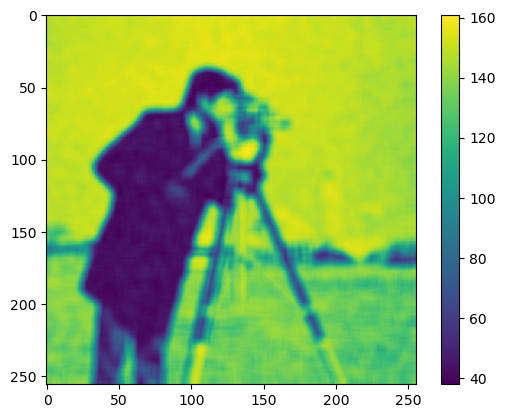

In [18]:
plt.imshow(denoised_image_255.astype(np.float32))
plt.colorbar()

In [19]:
print('MSE:', MSE)
print('PSNR:', PSNR)
print('SSIM:', ssim_value)

MSE: 1048.158
PSNR: 17.926536118103513
SSIM: 0.12362080922999082
